In [1]:
import l0module as l0
import torch.nn as nn                                                                                              
import torch

In [2]:
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F

from teacher import Teacher
from plot_history import plot_history, plot_gate_values

from tqdm.notebook import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import sys
    
device = torch.device('cuda:0')
normalize = transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
        std = (0.2023, 0.1994, 0.2010))
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=128, shuffle=True,
    num_workers=4, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False,
    num_workers=4, pin_memory=True)


Files already downloaded and verified


In [3]:
from teacher import Teacher

In [4]:
teacher1 = Teacher()
teacher1.load_state_dict(torch.load("teachers/model_0/best.checkpoint", map_location="cpu")["model_state_dict"])
teacher2 = Teacher()
teacher2.load_state_dict(torch.load("teachers/model_1/best.checkpoint", map_location="cpu")["model_state_dict"])

teacher1

in _make_layers [Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

Teacher(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (14): ReLU(inplace=True)
    (15): 

In [8]:
from itertools import chain

class Student(nn.Module):
    def __init__(self, t1, t2):
        super().__init__()
        features = []
        
        for i in range(22):
            if type(t1.features[i]) == nn.Conv2d:
                if i == 0:
                    features.append(l0.connect_first_conv2d(t1.features[i], t2.features[i]))
                else:
                    features.append(l0.connect_middle_conv(t1.features[i], t2.features[i]))
                f = features[-1].out_channels
            elif type(t1.features[i]) == nn.MaxPool2d or type(t1.features[i]) == nn.AvgPool2d:
                features.append(t1.features[i])
            elif type(t1.features[i]) == nn.ReLU:
                features.append(nn.ReLU())
                features.append(l0.L0GateLayer2d(f))
            else:
                print("wat", t1.features[i])
        
        self.features = nn.Sequential(*features)
        self.classifier = l0.connect_final_linear(t1.classifier, t2.classifier)
        
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    def l0_loss(self):                                                                                             
        l0_loss = 0
        for layer in self.features:  
            if type(layer) == l0.L0GateLayer2d:
                l0_loss += layer.l0_loss()                                                                             
        return l0_loss
    
    def gate_values(self):
        values = []
        for layer in self.features:
            if type(layer) == l0.L0GateLayer2d:
                values.append(layer.importance_of_features())

        return values
    
    def gate_parameters(self):
        parameters = []
        for layer in self.features:
            if type(layer) == l0.L0GateLayer2d:
                parameters.append(layer.parameters())
        return chain.from_iterable(parameters)


        
        
student = Student(teacher1, teacher2)
student, student.l0_loss()

(Student(
   (features): Sequential(
     (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (1): ReLU()
     (2): L0GateLayer2d()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (5): ReLU()
     (6): L0GateLayer2d()
     (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (9): ReLU()
     (10): L0GateLayer2d()
     (11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (12): ReLU()
     (13): L0GateLayer2d()
     (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (15): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (16): ReLU()
     (17): L0GateLayer2d()
     (18): Conv2d(1024, 1024, kernel

In [9]:
device = "cuda:1"
student.to(device)


student.eval()                                                                                             
running_test_loss = 0                                                                                      
correct_answers_test = 0                                                                                   
total_test = 0

for data, targets in test_loader:                                                                          
    data = data.to(device)                                                                                 
    targets = targets.to(device)                                                                           
    outputs = student(data)                                                                                
    loss = F.cross_entropy(outputs, targets)                                                               
    running_test_loss += loss.item()                                                                       
    _, predicted = torch.max(outputs.data, 1)                                                              
    correct_answers_test += (predicted == targets).sum().item()                                            
    total_test += len(targets) 
    
running_test_loss / len(test_loader), correct_answers_test / total_test

(1.571411837505389, 0.8039)

0.011 (0.7840567158768549, 1.487336183447972, 0.6867904512188102, 0.74514, 0.7802)
0.012048808848170152 (0.6099878923819803, 1.473908306082801, 0.6897008841550802, 0.79532, 0.7769)
0.013146479511355159 (0.5601086855849342, 1.454402058020882, 0.6160276690615883, 0.8139, 0.8029)
0.014293060494598608 (0.5301469230590878, 1.4342921883858684, 0.6330390900750703, 0.82382, 0.7949)
0.015488596378401292 (0.510458189965514, 1.4146939125817146, 0.614099216989324, 0.83124, 0.8021)
0.016733128273468723 (0.4900229246262699, 1.395344331746211, 0.6054394218740584, 0.83674, 0.8098)
0.018026694208141892 (0.4773081637099576, 1.3773949874941345, 0.542459433969063, 0.84162, 0.8235)
0.01936932946047746 (0.4788218274750673, 1.3608859753059914, 0.5814349323133879, 0.84254, 0.8116)
0.02076106684448629 (0.4721905506023056, 1.345143394701926, 0.5871581755861451, 0.84266, 0.8108)
0.022201936958149777 (0.46039955458982523, 1.3307588277265543, 0.5215363113940517, 0.84682, 0.8348)
0.0236919683993667 (0.4577968125148

0.2713101358640409 (0.1136425464888058, 0.8927552820471547, 0.31824185746380046, 0.96114, 0.9002)
0.2765188798188158 (0.11264011160472927, 0.8843809305249578, 0.3117197566205942, 0.9629, 0.9022)
0.28177738606887215 (0.10800033981633156, 0.8761812649724429, 0.3100017331823518, 0.96368, 0.9027)
0.28708565684256926 (0.11225468295690653, 0.8676337218650466, 0.3114161895988863, 0.96212, 0.9024)
0.29244369432697126 (0.1108196785297159, 0.8588359651663114, 0.3087412384869177, 0.96184, 0.9029)
0.2978515006689825 (0.10927510098613741, 0.8498577839883087, 0.3073890275215801, 0.96348, 0.9026)
0.30330907797644213 (0.1105829459303023, 0.8405956859173982, 0.31876541768448263, 0.96294, 0.8997)
0.30881642831917905 (0.10607572045663129, 0.8313656729810378, 0.3074717889480953, 0.96418, 0.9021)
0.31437355373002934 (0.10768188485194502, 0.8220540391819556, 0.30895137862314154, 0.96444, 0.9008)
0.31998045620581783 (0.10799280279185004, 0.812565302757351, 0.31923072605947905, 0.96382, 0.8974)
0.325637137708

([(0.7840567158768549, 1.487336183447972, 0.6867904512188102, 0.74514, 0.7802),
  (0.6099878923819803, 1.473908306082801, 0.6897008841550802, 0.79532, 0.7769),
  (0.5601086855849342, 1.454402058020882, 0.6160276690615883, 0.8139, 0.8029),
  (0.5301469230590878,
   1.4342921883858684,
   0.6330390900750703,
   0.82382,
   0.7949),
  (0.510458189965514, 1.4146939125817146, 0.614099216989324, 0.83124, 0.8021),
  (0.4900229246262699, 1.395344331746211, 0.6054394218740584, 0.83674, 0.8098),
  (0.4773081637099576, 1.3773949874941345, 0.542459433969063, 0.84162, 0.8235),
  (0.4788218274750673,
   1.3608859753059914,
   0.5814349323133879,
   0.84254,
   0.8116),
  (0.4721905506023056, 1.345143394701926, 0.5871581755861451, 0.84266, 0.8108),
  (0.46039955458982523,
   1.3307588277265543,
   0.5215363113940517,
   0.84682,
   0.8348),
  (0.45779681251481974,
   1.3175091740420408,
   0.5500336561021926,
   0.84706,
   0.818),
  (0.45767468564650593,
   1.3054732056834815,
   0.5545652595501912,

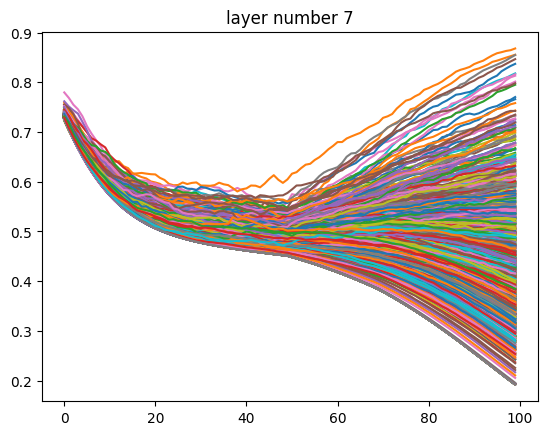

In [10]:
import math

def train_student_first_stage(student):
    device = torch.device('cuda:1')
    student.to(device)

    optimizer1 = SGD(student.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
    scheduler1 = MultiStepLR(optimizer1, milestones=[50, 70], gamma=0.1)
    optimizer2 = SGD(student.gate_parameters(), lr=0.2, momentum=0.9)
    
    history = []
    gate_values = []
    alpha = 0.01
    for _ in range(100):
        alpha += 0.01 * math.sqrt(alpha)
        student.train()
        running_training_main_loss = 0
        running_training_l0_loss = 0
        correct_answers_train = 0
        total_train = 0

        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)
            optimizer1.zero_grad()
            optimizer2.zero_grad()

            outputs = student(data)
            main_loss = F.cross_entropy(outputs, targets)
            l0_loss = student.l0_loss()
            loss = main_loss + alpha * l0_loss
            loss.backward()

            optimizer1.step()
            optimizer2.step()

            running_training_main_loss += main_loss.item()
            running_training_l0_loss += l0_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_answers_train += (predicted == targets).sum().item()
            total_train += len(targets)

        student.eval()
        running_test_loss = 0
        correct_answers_test = 0
        total_test = 0

        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            outputs = student(data)
            loss = F.cross_entropy(outputs, targets)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_answers_test += (predicted == targets).sum().item()
            total_test += len(targets)

        scheduler1.step()

        print(alpha, (running_training_main_loss / len(train_loader), running_training_l0_loss / len(train_loader),
                        running_test_loss / len(test_loader), correct_answers_train / total_train,
                        correct_answers_test / total_test))

        history.append((running_training_main_loss / len(train_loader), running_training_l0_loss / len(train_loader),
                        running_test_loss / len(test_loader), correct_answers_train / total_train,
                        correct_answers_test / total_test))
        gate_values.append(student.gate_values())

        plot_gate_values(gate_values, 2)
    return history, gate_values

train_student_first_stage(student)

In [11]:
torch.save(student.state_dict(), "students/std1.pt")

In [29]:
out_student = Teacher()

ln = 0
out_gate = torch.ones(3, dtype=torch.bool)
for i in range(22):
    if type(out_student.features[i]) == nn.Conv2d:
        source = student.features[i+ln]
        in_gate = out_gate
        out_gate = student.features[i+ln+2].important_indices()
        
        out_student.features[i] = l0.compress_conv2d(source, in_gate, out_gate)
        ln += 1

def compress_final_linear(layer: nn.Linear, in_important_indices) -> nn.Linear:
    compressed = nn.Linear(len(in_important_indices), layer.out_features)
    compressed.weight.data = layer.weight.data[:, in_important_indices].detach().clone()
#    compressed.bias.data = layer.bias.data.detach().clone()
    return compressed


out_student.classifier = compress_final_linear(student.classifier, out_gate)

in _make_layers [Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [30]:
device = "cuda:1"
out_student.to(device)


out_student.eval()                                                                                             
running_test_loss = 0                                                                                      
correct_answers_test = 0                                                                                   
total_test = 0

for data, targets in test_loader:                                                                          
    data = data.to(device)                                                                                 
    targets = targets.to(device)                                                                           
    outputs = out_student(data)                                                                                
    loss = F.cross_entropy(outputs, targets)                                                               
    running_test_loss += loss.item()                                                                       
    _, predicted = torch.max(outputs.data, 1)                                                              
    correct_answers_test += (predicted == targets).sum().item()                                            
    total_test += len(targets) 
    
running_test_loss / len(test_loader), correct_answers_test / total_test

(1.0544103731082966, 0.7957)

In [31]:
def train_student_second_stage(student):
    device = torch.device('cuda:1')
    student.to(device)

    optimizer = SGD(student.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
    scheduler = MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

    history = []
    for epoch in range(100):
        student.train()
        running_training_loss = 0
        correct_answers_train = 0
        total_train = 0

        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = student(data)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()

            running_training_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_answers_train += (predicted == targets).sum().item()
            total_train += len(targets)

        student.eval()
        running_test_loss = 0
        correct_answers_test = 0
        total_test = 0

        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            outputs = student(data)
            loss = F.cross_entropy(outputs, targets)

            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_answers_test += (predicted == targets).sum().item()
            total_test += len(targets)

        scheduler.step()
        print(epoch, (running_training_loss / len(train_loader), running_test_loss / len(test_loader),
                        correct_answers_train / total_train,
                        correct_answers_test / total_test))

        history.append((running_training_loss / len(train_loader), running_test_loss / len(test_loader),
                        correct_answers_train / total_train,
                        correct_answers_test / total_test))
    return history

train_student_second_stage(out_student)

0 (0.6857374904253294, 0.6181636105609846, 0.77478, 0.7942)
1 (0.506908663550911, 0.5905905577200877, 0.83166, 0.8091)
2 (0.45629809587203024, 0.6216658327398421, 0.84716, 0.7967)
3 (0.42939174903170835, 0.49371670997595485, 0.85806, 0.8421)
4 (0.4176507157361721, 0.48078022369101076, 0.8611, 0.8461)
5 (0.4099773956305536, 0.5566244332850734, 0.86466, 0.8165)
6 (0.39418439334615724, 0.49963953977898706, 0.86768, 0.8337)
7 (0.3885645065694819, 0.5052942999556095, 0.86952, 0.839)
8 (0.3805824828803387, 0.5048981618277634, 0.8736, 0.8368)
9 (0.36406346865932043, 0.4988662721235541, 0.87812, 0.8375)
10 (0.3628157234329092, 0.4587906606589692, 0.87912, 0.8547)
11 (0.36362654679571577, 0.4780629665791234, 0.87806, 0.8445)
12 (0.3604379532206089, 0.45579486293128774, 0.87958, 0.8476)
13 (0.35432084099106165, 0.5019748591924016, 0.88226, 0.8392)
14 (0.35950395068549135, 0.4631724806526039, 0.88098, 0.8504)
15 (0.35021138366530924, 0.5219293768647351, 0.8819, 0.8288)
16 (0.3563207400881726, 0.5

[(0.6857374904253294, 0.6181636105609846, 0.77478, 0.7942),
 (0.506908663550911, 0.5905905577200877, 0.83166, 0.8091),
 (0.45629809587203024, 0.6216658327398421, 0.84716, 0.7967),
 (0.42939174903170835, 0.49371670997595485, 0.85806, 0.8421),
 (0.4176507157361721, 0.48078022369101076, 0.8611, 0.8461),
 (0.4099773956305536, 0.5566244332850734, 0.86466, 0.8165),
 (0.39418439334615724, 0.49963953977898706, 0.86768, 0.8337),
 (0.3885645065694819, 0.5052942999556095, 0.86952, 0.839),
 (0.3805824828803387, 0.5048981618277634, 0.8736, 0.8368),
 (0.36406346865932043, 0.4988662721235541, 0.87812, 0.8375),
 (0.3628157234329092, 0.4587906606589692, 0.87912, 0.8547),
 (0.36362654679571577, 0.4780629665791234, 0.87806, 0.8445),
 (0.3604379532206089, 0.45579486293128774, 0.87958, 0.8476),
 (0.35432084099106165, 0.5019748591924016, 0.88226, 0.8392),
 (0.35950395068549135, 0.4631724806526039, 0.88098, 0.8504),
 (0.35021138366530924, 0.5219293768647351, 0.8819, 0.8288),
 (0.3563207400881726, 0.507288293

In [32]:
out_student = Teacher()

ln = 0
out_gate = torch.ones(3, dtype=torch.bool)
for i in range(22):
    if type(out_student.features[i]) == nn.Conv2d:
        source = student.features[i+ln]
        in_gate = out_gate
        out_gate = student.features[i+ln+2].important_indices()
        
        out_student.features[i] = l0.compress_conv2d(source, in_gate, out_gate)
        ln += 1

def compress_final_linear(layer: nn.Linear, in_important_indices) -> nn.Linear:
    compressed = nn.Linear(len(in_important_indices), layer.out_features, bias=False)
    compressed.weight.data = layer.weight.data[:, in_important_indices].detach().clone()
#    compressed.bias.data = layer.bias.data.detach().clone()
    return compressed


out_student.classifier = compress_final_linear(student.classifier, out_gate)

in _make_layers [Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [ ]:
train_student_second_stage(out_student)

0 (0.6472796440276953, 0.5646176466458961, 0.78676, 0.8216)
1 (0.4949290876269645, 0.5128511835502673, 0.83634, 0.8357)
2 (0.45787421478639784, 0.5016468254071248, 0.84828, 0.8335)
3 (0.4326363372452119, 0.5255129691920702, 0.85724, 0.8286)
4 (0.401602727677816, 0.5034482520592364, 0.8663, 0.8361)
5 (0.3911969215821122, 0.45871407246287865, 0.86764, 0.8534)
6 (0.3801535582908279, 0.5280465083786204, 0.87376, 0.8264)
7 (0.3900498036685807, 0.48503394141981876, 0.8695, 0.8473)
8 (0.36868664340289964, 0.5096727998196324, 0.87904, 0.8389)
9 (0.3612786694941923, 0.4693908981884582, 0.87852, 0.8508)
10 (0.3607541193513919, 0.474563536010211, 0.8806, 0.8471)
11 (0.3597099324855048, 0.579808591664592, 0.87994, 0.8163)
12 (0.35336243953851176, 0.47865484711490097, 0.88182, 0.849)
13 (0.35465864959122884, 0.4934188112427917, 0.88154, 0.8431)
14 (0.35290698482252447, 0.47524109275280674, 0.8816, 0.8466)
15 (0.34680939883069917, 0.48027312755584717, 0.885, 0.8496)
16 (0.3449229937989998, 0.4808031